# Clasificación automática de tickets de atención al cliente mediante técnicas de NLP y Machine Learning

## Definición del problema y sus objetivos

###  Contexto del problema
En el ámbito de la atención al cliente digital, muchas organizaciones reciben diariamente cientos o miles de tickets de soporte, consultas, reclamaciones o solicitudes, a través de formularios web o correos electrónicos. Estos mensajes suelen ser procesados de forma manual por equipos de agentes humanos, lo que implica una inversión significativa de tiempo y recursos.

Uno de los mayores retos en este proceso es clasificar correctamente cada mensaje según el departamento que debe gestionarlo (por ejemplo: soporte técnico, atención comercial, facturación, etc.). Si esta asignación no es precisa o existe una alta demanda de solicitudes, se generan retrasos, reprocesos y menor satisfacción del cliente.

###  Problema a resolver
El proyecto parte de la necesidad de desarrollar un sistema automático capaz de clasificar mensajes entrantes de clientes según el departamento correspondiente, utilizando técnicas de procesamiento de lenguaje natural (NLP) y aprendizaje automático. El objetivo principal es mejorar la eficiencia y velocidad en el manejo de tickets, especialmente en organizaciones que reciben un gran volumen de consultas.

El conjunto de datos utilizado simula un entorno sintético de atención al cliente extraído de Kaggle. Contiene ejemplos de tickets con su asunto, cuerpo del mensaje, etiquetas y metadatos (idioma, prioridad, tipo de solicitud, etc.).

### Objetivos del proyecto
Objetivo general:
- Diseñar, entrenar y evaluar un modelo de clasificación automática de tickets de clientes, capaz de predecir con alta precisión el departamento destino de cada mensaje.

Objetivos específicos:
- Realizar una exploración inicial del dataset, evaluando la distribución de clases, calidad del texto y características disponibles.

- Aplicar técnicas de preprocesamiento lingüístico (tokenización, lematización, limpieza de texto).

- Probar diferentes métodos de vectorización del texto (TF-IDF, embeddings).

- Comparar el rendimiento de varios modelos de clasificación (por ejemplo, Random Forest, Naive Bayes, Regresión Logística).

- Tratar el desbalanceo de clases mediante técnicas como sobre-muestreo o ponderación de clases.

- Evaluar el modelo utilizando métricas adecuadas (precisión, recall, F1-score) y analizar errores frecuentes.

- Estudiar la interpretabilidad del modelo mediante visualización de palabras clave o explicaciones tipo SHAP.

In [1]:
!pip install pandas
!pip install scikit-learn
!pip install spacy
!pip install matplotlib
!pip install imbalanced-learn

#### Explora los datos y comparte tus observaciones.
Antes de entrenar un modelo de clasificación, es fundamental aplicar un proceso de limpieza al conjunto de datos. Esto garantiza que los textos estén normalizados, libres de ruido y listos para ser vectorizados de forma efectiva. No obstante, primero exploraremos nuestros datos. A continuación se detallan los pasos realizados y su justificación.

Para facilitar la reproducibilidad del proyecto, el conjunto de datos se descarga directamente desde la plataforma Kaggle utilizando la herramienta kagglehub.

In [2]:
# Instalamos kagglehub para poder utilizar la API y descargar el archivo csv
!pip install kagglehub

In [3]:
import kagglehub

# Descargamos del dataset y nos devuelve el path:
path = kagglehub.dataset_download("tobiasbueck/multilingual-customer-support-tickets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/multilingual-customer-support-tickets


Una vez ejecutado, el path (ruta) que nos devuelve el código, es la que deberemos utilizar para poder trabajar con el dataset descargado.

In [8]:
import os
import pandas as pd

# Nombre exacto del archivo deseado
filename = "aa_dataset-tickets-multi-lang-5-2-50-version.csv"

# Construimos la ruta completa
csv_path = os.path.join(path, filename)

# Leemos el archivo CSV deseado
df = pd.read_csv(csv_path)

# Confirmamos la carga
print("Tamaño del dataset:", df.shape)
df.head()

Tamaño del dataset: (28587, 16)


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN


In [9]:
print("Columnas del CSV cargado:")
print(df.columns.tolist())

Columnas del CSV cargado:
['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']


A continuación, filtraremos los datos por idioma ("en") y seleccionaremos únicamente las columnas necesarias para el análisis.

In [10]:
# Filtramos solo tickets en inglés:
df = df[df["language"] == "en"].copy()

# Nos quedamos solo con las columnas clave:
df = df[["subject", "body", "queue"]].copy()

df.head()

,subject,body,queue
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...",Technical Support
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Returns and Exchanges
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",Billing and Payments
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Sales and Pre-Sales
5,Feature Query,"Dear Customer Support,\n\nI hope this message ...",Technical Support


Una vez cargados los datos, procedemos a realizar un pequeñ análisis exploratorio.

In [11]:
import pandas as pd

# Tamaño del dataset:
print("Tamaño del dataset (filas, columnas):")
print(df.shape)

# Información general del dataset:
print("\nInformación general del dataset:")
df.info()

# Porcentaje de valores nulos por columna:
print("\nPorcentaje de valores nulos por columna:")
print((df.isnull().sum() / len(df) * 100).round(2))

# Número de valores únicos por columna:
print("\nNúmero de valores únicos por columna:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")

# Análisis de duplicados:
print("\n¿Hay duplicados exactos?")
print("→", df.duplicated().any())
print("Número de duplicados:", df.duplicated().sum())
print("\nEjemplos de filas duplicadas (si existen):")
display(df[df.duplicated()].head())

Tamaño del dataset (filas, columnas):
(16338, 3)

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 16338 entries, 1 to 28586
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  13731 non-null  object
 1   body     16338 non-null  object
 2   queue    16338 non-null  object
dtypes: object(3)
memory usage: 510.6+ KB

Porcentaje de valores nulos por columna:
subject    15.96
body        0.00
queue       0.00
dtype: float64

Número de valores únicos por columna:
subject: 13731 valores únicos
body: 16338 valores únicos
queue: 10 valores únicos

¿Hay duplicados exactos?
→ False
Número de duplicados: 0

Ejemplos de filas duplicadas (si existen):


,subject,body,queue


El dataset contiene un total de 16.338 registros y 3 columnas principales: subject, body y queue. Las columnas body y queue están completas, mientras que subject presenta un 15,96 % de valores nulos. No se han detectado filas duplicadas. Cada fila representa un ticket único, y existen 10 posibles valores distintos en queue, lo que indica que los tickets se distribuyen entre 10 departamentos. La columna body, que contiene el texto principal de cada consulta, es única en todos los casos, lo cual confirma la unicidad del contenido por registro y refuerza la calidad del conjunto para tareas de clasificación de texto.

#### Distribución de clases en la variable objetivo
Es importante revisar este aspecto, ya que la variable «queue» representa el departamento al que se asigna cada ticket. Por ello, conviene analizar su distribución para detectar posibles desbalances entre clases.

Distribución de clases en la columna 'queue':
queue
Technical Support                  4737
Product Support                    3073
Customer Service                   2410
IT Support                         1942
Billing and Payments               1595
Returns and Exchanges               820
Service Outages and Maintenance     664
Sales and Pre-Sales                 513
Human Resources                     348
General Inquiry                     236
Name: count, dtype: int64


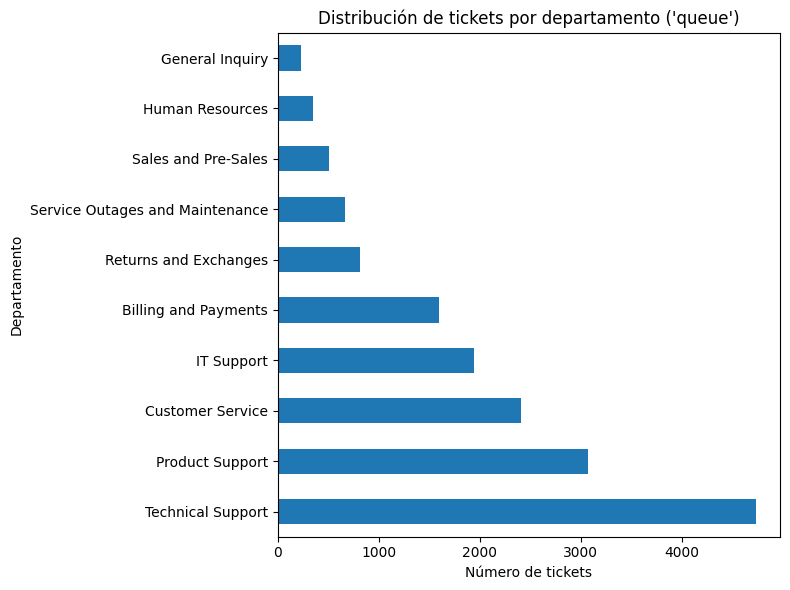

In [12]:
# Distribución de clases en la variable objetivo:
print("Distribución de clases en la columna 'queue':")
print(df['queue'].value_counts())

# Visualización con gráfico de barras:
import matplotlib.pyplot as plt

df['queue'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.title("Distribución de tickets por departamento ('queue')")
plt.xlabel("Número de tickets")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

La variable objetivo "queue", que indica el departamento al que se dirige cada ticket, presenta una distribución claramente desbalanceada. Las tres categorías principales —Technical Support, Product Support y Customer Service— concentran más del 60 % del total de registros, mientras que otras como General Inquiry o Human Resources tienen una representación muy reducida. Este desbalance puede afectar al rendimiento del modelo, especialmente en la predicción de clases minoritarias, por lo que será necesario tenerlo en cuenta durante la fase de entrenamiento y evaluación mediante técnicas como stratify, ponderación de clases o resampling.

#### Limpieza de datos
Procederemos a hacer una limpieza lingüística, ya que tenemos hecho la estructural.
Haremos lo siguiente:
- Eliminamos duplicados
- Completamos valores nulos
- Concatenamos subject + body y eliminamos espacios redundantes
- Normalizamos texto (minúsculas + eliminación de símbolos)

In [13]:
import re # Importamos la librería re para trabajar con expresiones regulares

# Elimina duplicados exactos en las columnas 'subject' y 'body'
def eliminar_duplicados(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop_duplicates(subset=["subject", "body"]).copy()

# Rellena los valores nulos en 'subject' y 'body' con cadenas vacías para evitar errores
def completar_nulos(df: pd.DataFrame) -> pd.DataFrame:
    df["subject"] = df["subject"].fillna("")  # Reemplaza NaN en 'subject'
    df["body"] = df["body"].fillna("")        # Reemplaza NaN en 'body'
    return df

# Combina las columnas 'subject' y 'body' en un único campo de texto ('text') para un análisis conjunto
def combinar_campos(df: pd.DataFrame) -> pd.DataFrame:
    texto_combinado = df["subject"] + ". " + df["body"]
    texto_combinado = texto_combinado.str.replace(r"\s+", " ", regex=True)  # Normaliza espacios
    texto_combinado = texto_combinado.str.strip()  # Elimina espacios extremos
    df["text"] = texto_combinado
    return df

def combinar_campos(df: pd.DataFrame) -> pd.DataFrame:
    texto_combinado = df["subject"] + ". " + df["body"]

    # Limpiamos saltos de línea y tabulaciones escapadas o reales
    texto_combinado = texto_combinado.str.replace(r"(\\n|\\t|\n|\t)", " ", regex=True)
    texto_combinado = texto_combinado.str.replace(r"\s+", " ", regex=True)  # Normaliza espacios múltiples
    texto_combinado = texto_combinado.str.strip()  # Elimina espacios extremos

    df["text"] = texto_combinado
    return df


# Limpieza del texto combinando varias transformaciones
def normalizar_texto(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convierte el texto a minúsculas y elimina símbolos no alfabéticos
    (excepto apóstrofes y guiones, que pueden ser significativos en nombres o contracciones).
    """
    regex_keep = r"[^a-z\s'\-]"  # Define qué caracteres no deseamos (todo excepto letras, espacio, apóstrofe y guion)
    df["text"] = (
        df["text"]
        .str.lower()  # Convierte a minúsculas
        .str.replace(regex_keep, "", regex=True)  # Elimina caracteres no deseados
        .str.strip()  # Elimina espacios al principio y al final
    )
    return df

In [14]:
# Ejecutamos nuestro pipeline de limpieza:
df = eliminar_duplicados(df)
df = completar_nulos(df)
df = combinar_campos(df)
df = normalizar_texto(df)

In [15]:
# No podemos aplicar regex a esta columna como tal, lo debemos hacer por separado:
df['queue'] = df['queue'].str.strip().str.lower()
df.shape
df.head()

,subject,body,queue,text
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...",technical support,account disruption dear customer support team ...
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",returns and exchanges,query about smart home system integration feat...
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",billing and payments,inquiry regarding invoice details dear custome...
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",sales and pre-sales,question about marketing agency software compa...
5,Feature Query,"Dear Customer Support,\n\nI hope this message ...",technical support,feature query dear customer support i hope thi...


In [16]:
print(df["text"].iloc[0])

account disruption dear customer support team i am writing to report a significant problem with the centralized account management portal which currently appears to be offline this outage is blocking access to account settings leading to substantial inconvenience i have attempted to log in multiple times using different browsers and devices but the issue persists could you please provide an update on the outage status and an estimated time for resolution also are there any alternative ways to access and manage my account during this downtime


#### Preprocesamiento lingüístico y análisis semántico previo

Para mejorar la calidad del texto antes del modelado, se aplicó lematización al campo combinado `text` (formado por *subject* y *body*), utilizando **spaCy** y su modelo en inglés `en_core_web_sm`. Este proceso reduce las palabras a su forma base, eliminando variaciones morfológicas y descartando signos de puntuación y espacios, conservando solo *tokens* relevantes. Tras la lematización, se creó un nuevo DataFrame (`df_limpio`) sobre el que se realizó un análisis exploratorio usando `CountVectorizer` para identificar los términos más representativos por clase (`queue`), aplicando filtros de *stopwords* y considerando tanto *unigramas* como *bigramas*.

In [17]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

# Cargamos y configuramos spacy para lematización
try:
    nlp = spacy.load("en_core_web_sm")  # Intentamos cargar el modelo de lenguaje en inglés (pequeño) de spaCy
except OSError:
    from spacy.cli import download       # Si no está instalado, importamos el comando para descargar modelos
    download("en_core_web_sm")           # Descargamos el modelo "en_core_web_sm"
    nlp = spacy.load("en_core_web_sm")   # Volvemos a intentar cargar el modelo ya descargado


def lemmatize(text: str) -> str:
    """
    Devuelve una versión lematizada del texto,
    eliminando puntuación y espacios.
    """
    doc = nlp(text)  # Procesamos el texto con spaCy para obtener tokens con atributos lingüísticos
    return ' '.join(
        token.lemma_ for token in doc           # Extraemos la raíz (lema) de cada token
        if not token.is_punct and not token.is_space  # Excluimos signos de puntuación y espacios
    )


df_limpio = df.copy()   # aseguramos copia independiente

# Aplicar lematización sobre la columna combinada
df_limpio['text'] = df_limpio['text'].apply(lemmatize)

Para explorar los términos más representativos de cada clase, aplicamos un análisis de frecuencia utilizando CountVectorizer. Calculamos los 10 unigramas y bigramas más frecuentes por clase (departamento) eliminando palabras vacías en inglés. Esto nos permitió entender mejor qué vocabulario es más común en cada tipo de ticket, lo cual resulta útil revisar términas repetitivos que no aportan valor y puedan sesgar nuestro modelo.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def top_terms_por_clase(df: pd.DataFrame, columna_texto: str, columna_clase: str, n: int = 10, ngrama=(1, 1)) -> pd.DataFrame:
    """
    Calcula los términos más frecuentes (unigramas o bigramas) por clase.

    Parámetros:
    - df: DataFrame con los textos y sus etiquetas de clase.
    - columna_texto: nombre de la columna que contiene el texto lematizado.
    - columna_clase: nombre de la columna que contiene la clase (ej. 'queue').
    - n: número de términos más frecuentes a devolver por clase.
    - ngrama: tupla con el rango de ngramas a analizar (ej. (1,1)=unigramas, (2,2)=bigramas).

    Retorna:
    - DataFrame con columnas: Clase, Término, Frecuencia.
    """

    resultados = []

    # Iteramos por cada clase única (departamento)
    clases = df[columna_clase].unique()
    for clase in clases:
        # Filtramos solo los textos pertenecientes a esa clase
        subset = df[df[columna_clase] == clase]

        # Vectorizamos usando CountVectorizer para obtener frecuencia de términos
        vectorizer = CountVectorizer(
            ngram_range=ngrama,
            stop_words='english'  # Eliminamos stopwords para mayor claridad semántica
        )
        X = vectorizer.fit_transform(subset[columna_texto])

        # Suma total de cada término (suma columnas)
        suma = X.sum(axis=0)

        # Mapeamos términos y su frecuencia
        terminos = [
            (word, int(suma[0, idx]))
            for word, idx in vectorizer.vocabulary_.items()
        ]

        # Seleccionamos los n términos más frecuentes
        top = sorted(terminos, key=lambda x: x[1], reverse=True)[:n]

        # Guardamos resultados
        for termino, frecuencia in top:
            resultados.append({
                'Clase': clase,
                'Término': termino,
                'Frecuencia': frecuencia
            })

    # Convertimos resultados a DataFrame
    return pd.DataFrame(resultados)


# Aplicamos el análisis
df_top_unigramas = top_terms_por_clase(df_limpio, columna_texto='text', columna_clase='queue', n=10, ngrama=(1,1))
df_top_bigramas  = top_terms_por_clase(df_limpio, columna_texto='text', columna_clase='queue', n=10, ngrama=(2,2))

# Mostrar los unigramas más frecuentes por clase
print("Top 10 Unigramas por Clase")
display(df_top_unigramas)

# Mostrar los bigramas más frecuentes por clase
print("\nTop 10 Bigramas por Clase")
display(df_top_bigramas)

Top 10 Unigramas por Clase


,Clase,Término,Frecuencia
0,technical support,issue,4364
1,technical support,problem,2724
2,technical support,datum,2558
3,technical support,support,2348
4,technical support,update,2217
...,...,...,...
95,general inquiry,customer,99
96,general inquiry,tool,97
97,general inquiry,strategy,96
98,general inquiry,digital,95



Top 10 Bigramas por Clase


,Clase,Término,Frecuencia
0,technical support,customer support,1427
1,technical support,resolve issue,983
2,technical support,greatly appreciate,903
3,technical support,medical datum,827
4,technical support,project management,784
...,...,...,...
95,general inquiry,project management,37
96,general inquiry,medical datum,35
97,general inquiry,resolve issue,34
98,general inquiry,data analytic,32


In [20]:
df_top_unigramas.to_csv("top_unigramas.csv", index=False)
df_top_bigramas.to_csv("top_bigramas.csv", index=False)

Tras identificar los términos más frecuentes en los tickets mediante el análisis de unigramas y bigramas por clase, detectamos algunos patrones comunes de poco valor semántico o demasiado genéricos (como “dear customer” o “greatly appreciate”). Estos términos tienden a aparecer en todos los tipos de tickets, sin ayudar realmente a distinguir entre categorías.

Para reducir este “ruido contextual”, definimos listas manuales de unigramas y bigramas no informativos y aplicamos una función de limpieza basada en expresiones regulares. Esta limpieza mejora la calidad de los textos de entrada para el modelo, al centrarse en palabras verdaderamente discriminativas.

https://interactivechaos.com/es/python/function/reignorecase

In [21]:
import re

# Lista personalizada de UNIGRAMAS poco informativos o repetitivos
unigramas_ruido = [
    "issue", "appreciate", "support", "datum"
]

# Lista personalizada de BIGRAMAS típicos en plantillas o frases generales sin valor clasificatorio
bigramas_ruido = [
    "customer support", "dear customer", "greatly appreciate",
    "hear soon", "look forward", "forward hear",
    "reach inquire", "soon possible"
]

# Creamos un patrón regex para buscar y eliminar los BIGRAMAS (ignorando mayúsculas/minúsculas)
patron_bigramas = re.compile(
    r'\b(?:' + '|'.join(map(re.escape, bigramas_ruido)) + r')\b',
    flags=re.IGNORECASE
)

# Creamos un patrón regex para buscar y eliminar los UNIGRAMAS (también sin distinción de mayúsculas)
patron_unigramas = re.compile(
    r'\b(?:' + '|'.join(map(re.escape, unigramas_ruido)) + r')\b',
    flags=re.IGNORECASE
)

# Función de limpieza de ruido textual
def limpiar_ruido(text: str) -> str:
    """
    Elimina bigramas y unigramas definidos como ruido del texto de entrada.

    - Usa patrones precompilados para mayor eficiencia.
    - Reemplaza las coincidencias por cadena vacía.
    - Normaliza los espacios tras eliminación.

    Retorna: texto limpio y reducido de ruido contextual.
    """
    texto_sin_bigramas = patron_bigramas.sub('', text)
    texto_sin_unigramas = patron_unigramas.sub('', texto_sin_bigramas)
    texto_limpio = re.sub(r'\s+', ' ', texto_sin_unigramas).strip()  # Normaliza espacios
    return texto_limpio

# Aplicamos esta limpieza sobre la columna 'text' ya lematizada
df_limpio['text'] = df_limpio['text'].apply(limpiar_ruido)

In [24]:
# Seleccionamos un ejemplo cualquiera
ejemplo_original = df.iloc[0]["text"]
ejemplo_limpio = df_limpio.iloc[0]["text"]

# Mostramos ambos
print("Texto original (lematizado):\n")
print(ejemplo_original)
print("\nTexto después de aplicar limpieza de ruido:\n")
print(ejemplo_limpio)

Texto original (lematizado):

account disruption dear customer support team i am writing to report a significant problem with the centralized account management portal which currently appears to be offline this outage is blocking access to account settings leading to substantial inconvenience i have attempted to log in multiple times using different browsers and devices but the issue persists could you please provide an update on the outage status and an estimated time for resolution also are there any alternative ways to access and manage my account during this downtime

Texto después de aplicar limpieza de ruido:

account disruption team I be write to report a significant problem with the centralized account management portal which currently appear to be offline this outage be block access to account setting lead to substantial inconvenience I have attempt to log in multiple time use different browser and device but the persist could you please provide an update on the outage status 

In [25]:
# Comparamos el texto antes y después de la limpieza
cambios = df["text"] != df_limpio["text"]

# Número de registros afectados
n_afectados = cambios.sum()

print(f"Número de registros afectados por la eliminación de términos de ruido: {n_afectados} de {len(df)}")

Número de registros afectados por la eliminación de términos de ruido: 16309 de 16338


### 5.	Escoge un modelo y justifícalo.

In [26]:
# Seleccionamos las variables predictoras y la variable objetivo
X = df_limpio['text']
y = df_limpio['queue']   # ya está en minúsculas

# Codificamos la variable objetivo para el modelo
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# División en entrenamiento y prueba (80/20), manteniendo distribución de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded   # usamos stratify ya que tenemos desbalanceo de tipos
)

# Configuración vectorizador con TF-IDF:
vectorizador = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),   # se genera unigrama y bigramas
    max_features=20_000,
    min_df=5,          # elimina términos muy raros
    max_df=0.85,       # elimina términos demasiado comunes o que aparecen más del 85%
    sublinear_tf=True  # aplica logaritmo a las frecuencias, esto evita dominación de términos repetidos
)

# Aplicamos TF-IDF al conjunto de entrenamiento y test
X_train_tfidf = vectorizador.fit_transform(X_train)
X_test_tfidf  = vectorizador.transform(X_test)

print("Tamaño matriz TF-IDF (train):", X_train_tfidf.shape)

Tamaño matriz TF-IDF (train): (13070, 15446)


Tras aplicar la vectorización TF-IDF al conjunto de entrenamiento, obtenemos una matriz de tamaño (13070, 15446). Esto significa que el modelo trabajará con 13.070 muestras (tickets) y 15.446 características diferentes, que corresponden a los términos únicos (unigramas y bigramas) seleccionados según los criterios definidos en el vectorizador (min_df, max_df, stop_words, etc.).

Esta matriz escasa (sparse) representa la importancia relativa de cada término en cada documento, y constituye la base numérica que será utilizada por los algoritmos de clasificación. El hecho de que tengamos menos de las 20.000 características posibles (max_features) indica que, tras el filtrado por frecuencia, solo se han conservado 15.856 términos considerados relevantes en el corpus.

#### Balancear el conjunto de entrenamiento

Según la teoría investigada existe lo que es el sobremuestreo (Oversampling) y el submuestreo (Undersampling). En el sobremuestreo aumentamos el números de ejemplos de las clases minoritarias, aquí se puede aplicar SMOTE o RandomOverSampler (ROS). Por otro lado, el submuestreo reduce el número de ejemplo de las clases mayoritarias, eliminando lo que es parte de los datos, donde podemos aplicar RandomUnderSampler o Neighbourhood Cleaning Rule (NCL).



El conjunto está desbalanceado por clases (por ejemplo, algunas colas/tipos tienen muchos menos ejemplos que otras). Por ello, procederemos utilizar la técnica de oversampling.

RandomOverSampler es una técnica simple para balancear clases duplicando ejemplos aleatorios de las clases minoritarias hasta igualar la clase mayoritaria o el ratio que le especifiques.

Tamaño después del sobremuestreo: (37900, 15446)


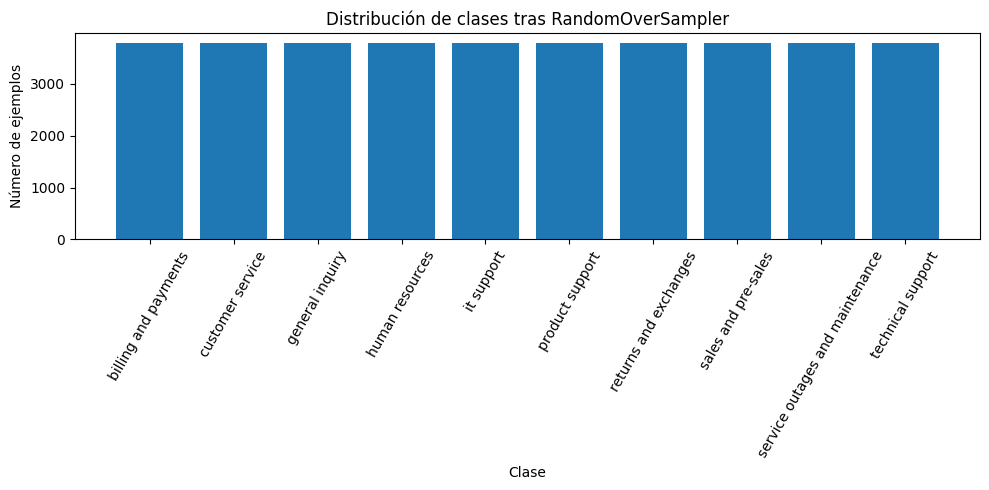

In [39]:
###### CODIGO PRUEBA ACTUALIZADO DIA 30/07 ######

from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt

# Balanceamos SOLO el conjunto de entrenamiento ya vectorizado
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_tfidf, y_train)

# Comprobamos nuevo tamaño
print("Tamaño después del sobremuestreo:", X_train_bal.shape)

# Visualizamos la nueva distribución de clases
unique, counts = np.unique(y_train_bal, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(encoder.inverse_transform(unique), counts)
plt.xticks(rotation=60)
plt.title("Distribución de clases tras RandomOverSampler")
plt.xlabel("Clase")
plt.ylabel("Número de ejemplos")
plt.tight_layout()
plt.show()

#### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Entrenamiento del modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_bal, y_train_bal)

# Predicción sobre el conjunto de prueba (sin balancear)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Métricas
print("Modelo: Random Forest")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=encoder.classes_))

Modelo: Random Forest
Accuracy: 0.7368
Reporte de clasificación:
                                 precision    recall  f1-score   support

           billing and payments       0.95      0.85      0.90       319
               customer service       0.67      0.70      0.68       482
                general inquiry       1.00      0.62      0.76        47
                human resources       0.96      0.66      0.78        70
                     it support       0.87      0.58      0.70       388
                product support       0.73      0.68      0.71       615
          returns and exchanges       0.94      0.60      0.74       164
            sales and pre-sales       0.97      0.58      0.73       103
service outages and maintenance       0.84      0.77      0.80       133
              technical support       0.64      0.87      0.74       947

                       accuracy                           0.74      3268
                      macro avg       0.86      0.69     

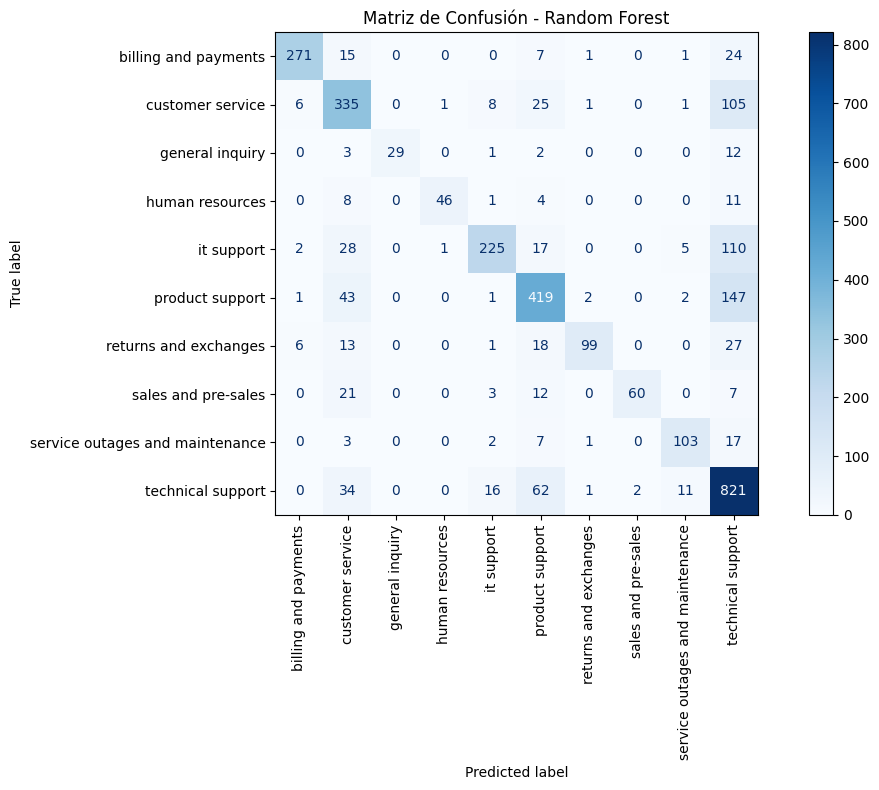

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Creamos figura y ejes personalizados:
fig, ax = plt.subplots(figsize=(12, 8))  # Aquí sí se respeta el tamaño

# Dibujamos matriz de confusión en el eje personalizado
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=encoder.classes_,
    xticks_rotation=90, cmap='Blues', ax=ax
)

plt.title("Matriz de Confusión - Random Forest")
plt.tight_layout()
plt.show()

#### Regresión Logística

In [46]:
from sklearn.linear_model import LogisticRegression

# Entrenamiento del modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000, solver='saga', random_state=42)
lr_model.fit(X_train_bal, y_train_bal)

# Predicción sobre el conjunto de prueba (sin balancear)
y_pred_lr = lr_model.predict(X_test_tfidf)

# Métricas
print("Modelo: Regresión Logística")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 4))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_lr, target_names=encoder.classes_))

Modelo: Regresión Logística
Accuracy: 0.5894
Reporte de clasificación:
                                 precision    recall  f1-score   support

           billing and payments       0.84      0.80      0.82       319
               customer service       0.53      0.54      0.54       482
                general inquiry       0.63      0.68      0.65        47
                human resources       0.65      0.69      0.67        70
                     it support       0.48      0.55      0.51       388
                product support       0.55      0.52      0.53       615
          returns and exchanges       0.54      0.59      0.57       164
            sales and pre-sales       0.49      0.63      0.55       103
service outages and maintenance       0.63      0.76      0.69       133
              technical support       0.63      0.56      0.60       947

                       accuracy                           0.59      3268
                      macro avg       0.60      0.6

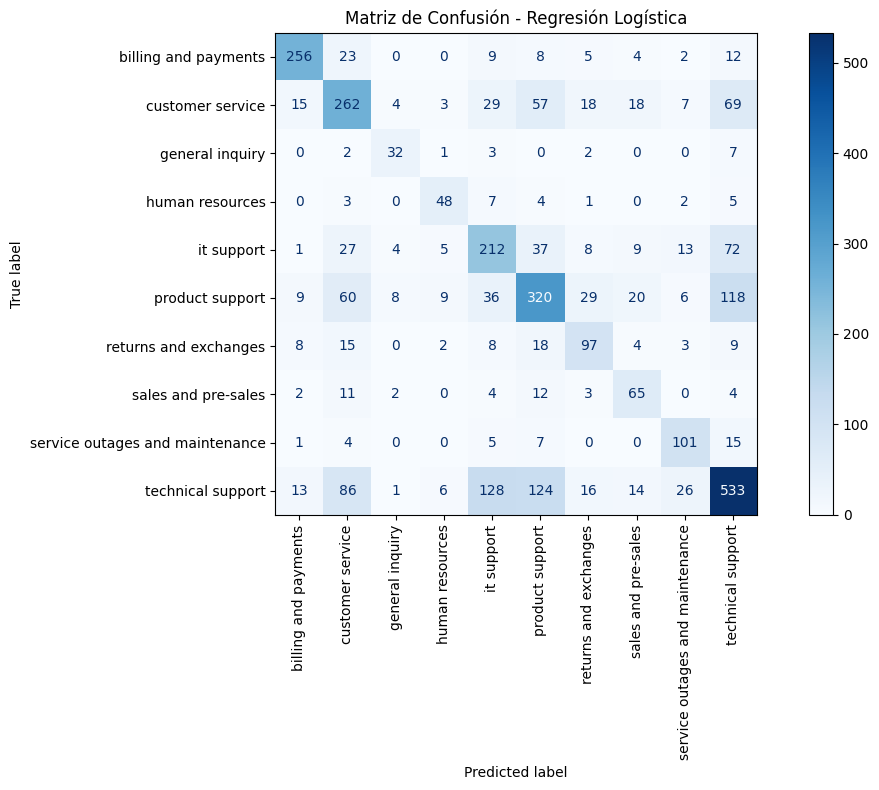

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Crear figura y ejes personalizados
fig, ax = plt.subplots(figsize=(12, 8))  # Este tamaño sí se respetará

# Dibujar la matriz de confusión con los resultados de regresión logística
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,                     # Reales y predichos
    display_labels=encoder.classes_,       # Etiquetas decodificadas
    xticks_rotation=90,                    # Rotar etiquetas del eje X
    cmap='Blues',                          # Mapa de colores
    ax=ax                                  # Usar el eje personalizado
)

plt.title("Matriz de Confusión - Regresión Logística")
plt.tight_layout()
plt.show()

#### Importancia de características con Random Forest y TF-IDF

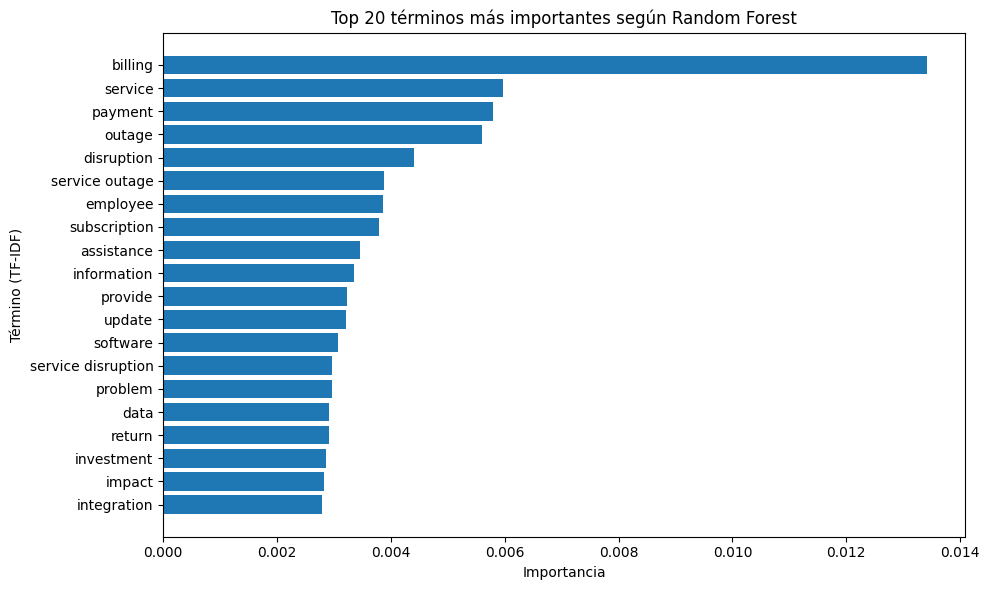

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extraemos las importancias del modelo ya entrenado
importancias = rf_model.feature_importances_

# Asociamos cada importancia a su término correspondiente en el vocabulario TF-IDF
nombres_caracteristicas = vectorizador.get_feature_names_out()

# Creamos un DataFrame ordenado con las características más importantes
df_importancias = pd.DataFrame({
    'termino': nombres_caracteristicas,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

# Mostramos las 20 características más relevantes
top_20 = df_importancias.head(20)

# Visualización con gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top_20['termino'][::-1], top_20['importancia'][::-1])  # Revertimos para ver de mayor a menor arriba
plt.xlabel("Importancia")
plt.ylabel("Término (TF-IDF)")
plt.title("Top 20 términos más importantes según Random Forest")
plt.tight_layout()
plt.show()

## Referencias:

https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets/data

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://openaccess.uoc.edu/server/api/core/bitstreams/a70f74bb-a78a-46d2-8f72-ee658e6bb197/content

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html